In [1]:
# !git clone https://www.github.com/dmc27/ai2023.git

# **Task 1. Distance-based color segmentation of the red flower**
## **1. Importing libraries**

In [145]:
# import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ai2023.imutils import imshow
from sklearn.cluster import KMeans
from scipy.sparse import issparse
from tqdm import tqdm

## **2. Reading the original, cropped image, and segmented area and converting it to RGB, HSV, and LAB**

In [408]:
img_rgb = cv2.cvtColor(cv2.imread('ai2023/1600.png'), cv2.COLOR_BGR2RGB)
img_rgb_crop = cv2.cvtColor(cv2.imread('ai2023/1600.crop.png'), cv2.COLOR_BGR2RGB)

img_hsv = cv2.cvtColor(cv2.imread('ai2023/1600.png'), cv2.COLOR_BGR2HSV)
img_hsv_crop = cv2.cvtColor(cv2.imread('ai2023/1600.crop.png'), cv2.COLOR_BGR2HSV)

img_lab = cv2.cvtColor(cv2.imread('ai2023/1600.png'), cv2.COLOR_BGR2LAB)
img_lab_crop = cv2.cvtColor(cv2.imread('ai2023/1600.crop.png'), cv2.COLOR_BGR2LAB)

segmented_area  = cv2.imread('ai2023/segmented_area.png', cv2.IMREAD_GRAYSCALE)

## **Exploratory Analysis (RGB)**

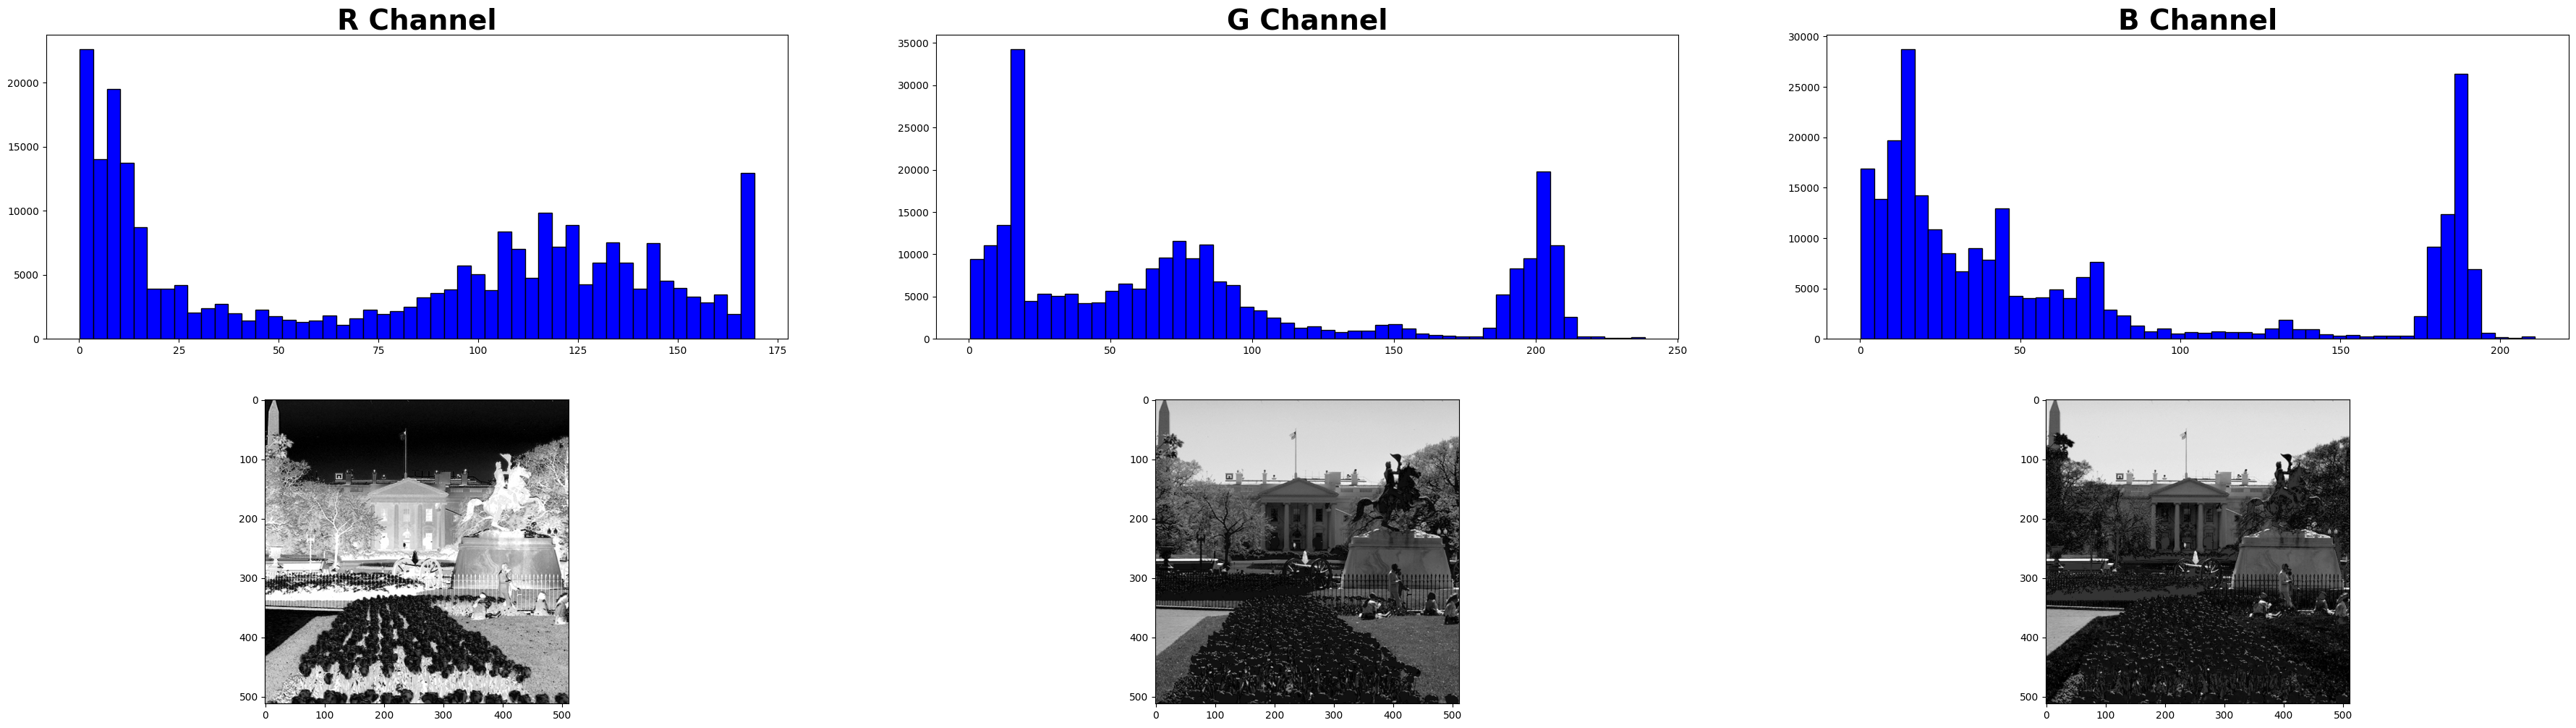

In [491]:
avg_rgb = np.mean(img_rgb_crop, axis = (0, 1))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = [45, 12])
ax1.hist(abs(img_rgb[:, :, 0].astype(np.float64).ravel() - avg_rgb[0]), bins = 50, edgecolor = 'black', color = 'b')
ax1.set_title('R Channel', fontsize = 28, fontweight = 'bold')

ax2.hist(abs(img_rgb[:, :, 1].ravel() - avg_rgb[1]), bins = 50, edgecolor = 'black', color = 'b')
ax2.set_title('G Channel', fontsize = 28, fontweight = 'bold')

ax3.hist(abs(img_rgb[:, :, 2].ravel() - avg_rgb[2]), bins = 50, edgecolor = 'black', color = 'b')
ax3.set_title('B Channel', fontsize = 28, fontweight = 'bold')

ax4.imshow((abs(img_rgb[:, :, 0].ravel() - avg_rgb[0])).reshape(512, 512), cmap = 'gray')
ax5.imshow((abs(img_rgb[:, :, 1].ravel() - avg_rgb[1])).reshape(512, 512), cmap = 'gray')
ax6.imshow((abs(img_rgb[:, :, 2].ravel() - avg_rgb[2])).reshape(512, 512), cmap = 'gray')

<font size="5.5"> 
The histograms shown in the figure above are the absolute difference or distance between the original "1600.png" image and the cropped image for Red, Green, and Blue channel. The absolute difference or distance is defined as
</font>

$$\partial_R = abs\left(I[R] - \left(\frac{1}{N}\sum_{i = 1}^{N}I[R]_i\right)\right)$$
$$\partial_G = abs\left(I[G] - \left(\frac{1}{N}\sum_{i = 1}^{N}I[G]_i\right)\right)$$
$$\partial_B = abs\left(I[B] - \left(\frac{1}{N}\sum_{i = 1}^{N}I[B]_i\right)\right)$$

<font size="5.5"> 
The cropped image contains a small portion of the red flower (rose) from the original image. By visualizing the absolute distance for each channels in the image, the distribution of the distance value can be seen. Starting with the first histogram (red channel), we can see that there are two ditributions (bimodal distribution). For the second histogram (green channel), there are at least three distributions (trimodal distribution). For the last histogram (blue channel), there are at least two distributions. This means that there are more than one class present in the image statistically. In addition, the figure shown below the histogram 
</font>

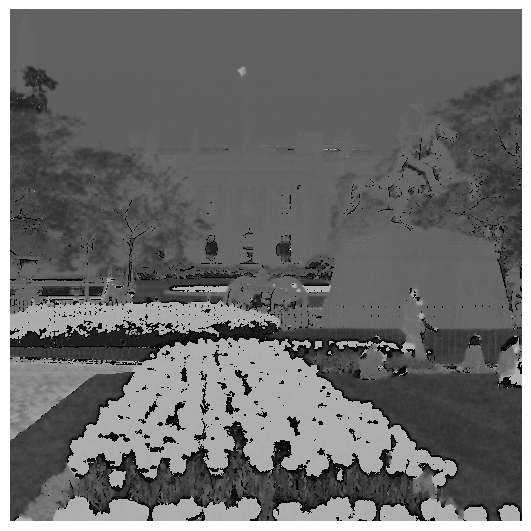

In [480]:
imshow(img_hsv[:, :, 0])

In [452]:
print(np.std(img_rgb_crop[:, :, 0]))
print(np.std(img_rgb_crop[:, :, 1]))
print(np.std(img_rgb_crop[:, :, 2]))

26.03328860796393
30.160438792201326
26.42712682214952


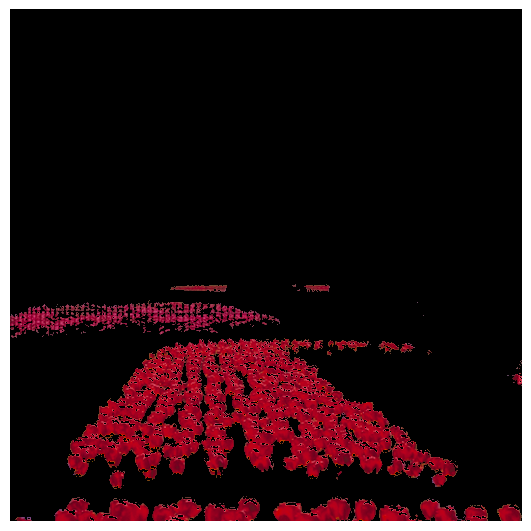

In [463]:
# Calculating the absolute distance
absolute_distance = abs(img_rgb.astype(np.float64) - np.mean(img_rgb_crop, axis = (0, 1)))
segmented_img_rgb = img_rgb * (absolute_distance[:, :,0][:,:, np.newaxis] < 80.) * (absolute_distance[:, :, 1][:,:, np.newaxis] < 60.) * (absolute_distance[:, :, 2][:,:, np.newaxis] < 110.)
imshow(segmented_img_rgb, zoom = 1)

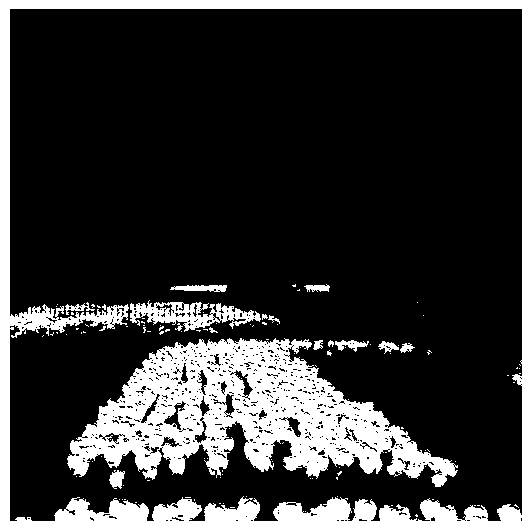

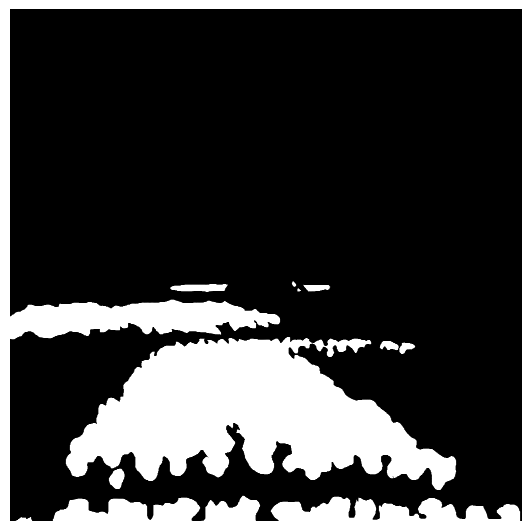

In [464]:
imshow(segmented_img_rgb[:, :, 0].astype(np.bool_) | segmented_img_rgb[:, :, 1].astype(np.bool_) | segmented_img_rgb[:, :, 2].astype(np.bool_) * 255)
imshow(segmented_area)

In [147]:
def euclidean_dist(x, train_rgb):
    mu = np.mean(train_rgb, axis = (0, 1))
    temp = x.astype(np.float64) - mu
    if temp.ndim == 1:
        eucl = np.sum(temp ** 2)
    else:
        eucl = np.sum(temp ** 2, axis = 2)
    return eucl ** 0.5

In [45]:
num_rows, num_cols = img_rgb.shape[0], img_rgb.shape[1]

In [209]:
euc_temp = euclidean_dist(img_rgb, img_rgb_crop)
euc_temp.shape
# np.where(euc_temp.ravel() < 100.)
img_out = img_rgb * (euc_temp[:, :, np.newaxis] < 100.)

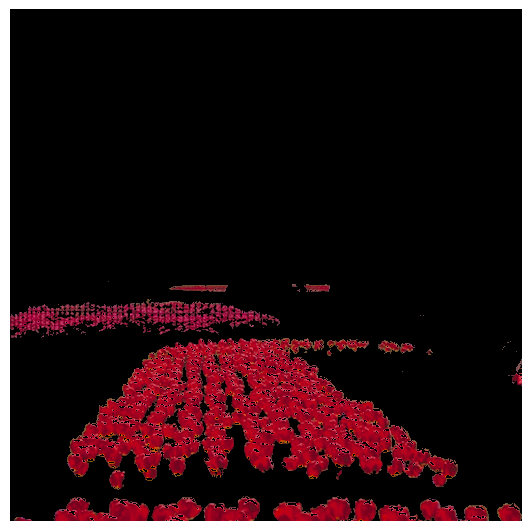

In [460]:

imshow(img_out, zoom = 1)

In [202]:
np.std(img_rgb[:, :, :])

72.93304036400646

In [134]:
img_rgb_out = img_rgb.copy()
rgb_euc_dist = []
for r in tqdm(range(0, num_rows)):
  for c in range(0, num_cols):
    euc_dist = euclidean_dist(img_rgb[r, c], img_rgb_crop)
    rgb_euc_dist.append(euc_dist)

    if euc_dist < 250. and euc_dist >= 225.:
      img_rgb_out[r, c] = img_rgb[r, c]
    else:
      img_rgb_out[r, c]= np.array([0, 0, 0], dtype=np.uint8)

100%|██████████| 512/512 [00:07<00:00, 70.82it/s]


In [233]:
np.std(img_rgb_crop, axis = (0, 1))

array([26.03328861, 30.16043879, 26.42712682])

(array([13351.,  4397.,  3195.,  2988.,  2773.,  3958.,  3537.,  4744.,
         4019.,  4331.,  6597.,  5990.,  6043.,  7913.,  9273., 11377.,
        14088., 15177., 15531., 14334., 11736.,  7350.,  5441.,  3941.,
         2899.,  2459.,  1985.,  1697.,  1435.,  1060.,  1185.,   897.,
         1006.,  1522.,  1894.,  1432.,   837.,   422.,   445.,  3723.,
        10936., 15489., 17106.,  8783.,  1832.,   345.,   241.,   123.,
          104.,   203.]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 127.5, 132.6,
        137.7, 142.8, 147.9, 153. , 158.1, 163.2, 168.3, 173.4, 178.5,
        183.6, 188.7, 193.8, 198.9, 204. , 209.1, 214.2, 219.3, 224.4,
        229.5, 234.6, 239.7, 244.8, 249.9, 255. ]),
 <BarContainer object of 50 artists>)

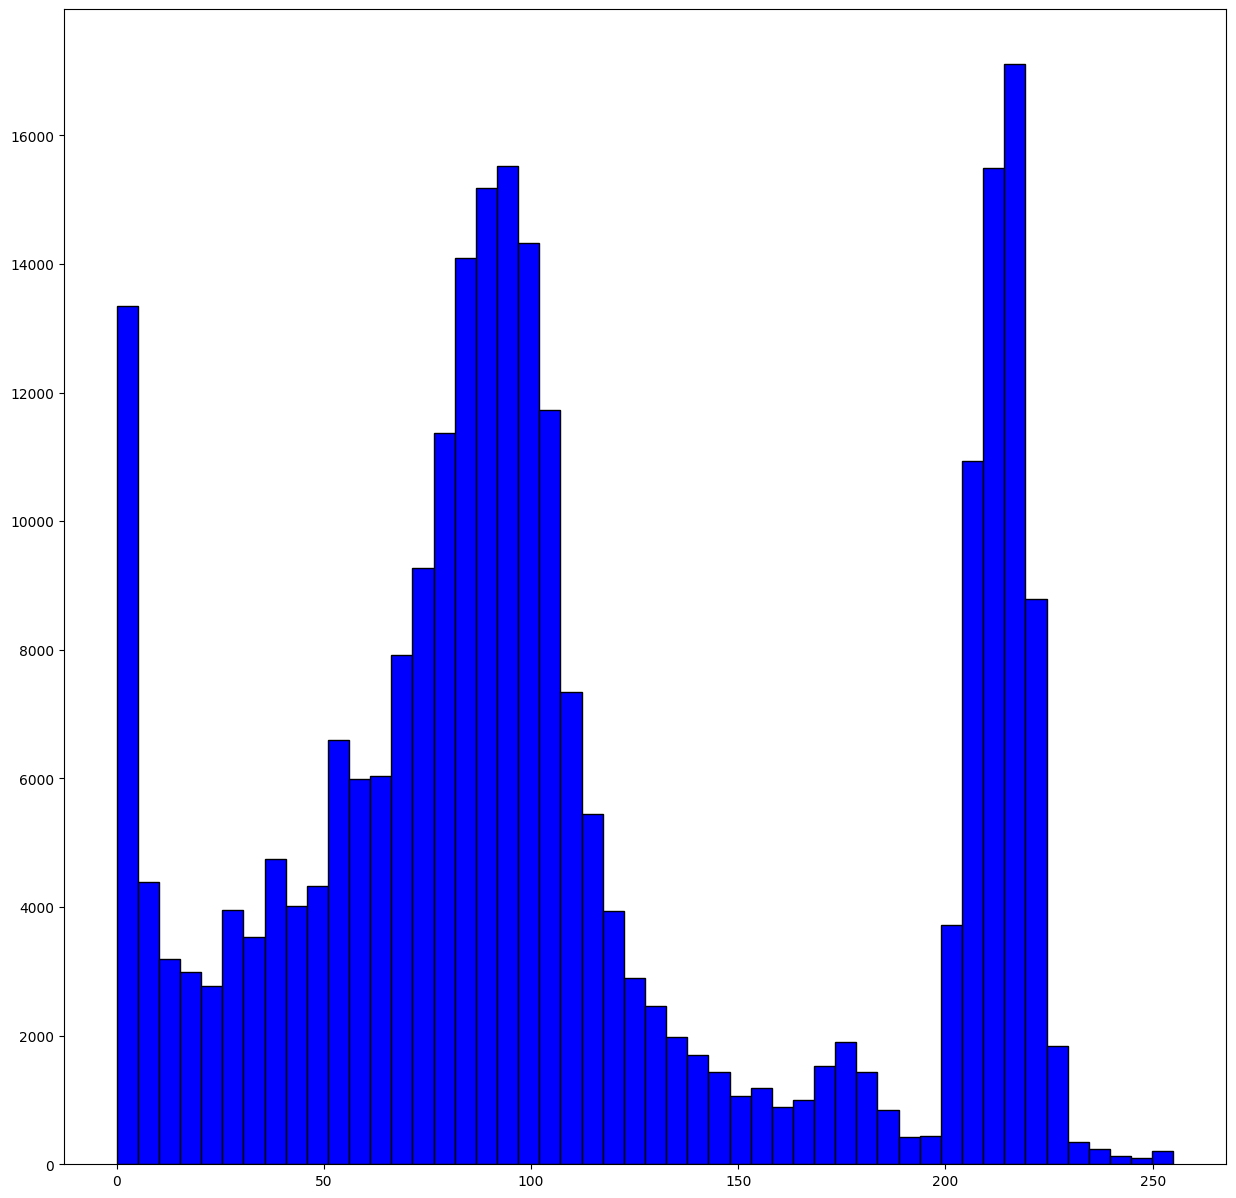

In [242]:
plt.figure(figsize = [15, 15])
i = 1
# plt.hist((abs(img_lab[:, :, i] - np.mean(img_lab_crop, axis = (0, 1))[i])).ravel(), bins= 50, edgecolor = 'black', color = 'b')
plt.hist(img_lab[:, :, 0].ravel(), bins= 50, edgecolor = 'black', color = 'b')
# plt.hist((abs(img_hsv[:, :, i] - np.mean(img_hsv_crop, axis = (0, 1))[i])).ravel(), bins= 50, edgecolor = 'black', color = 'b')
# plt.xticks(np.arange(0, 450, 25))

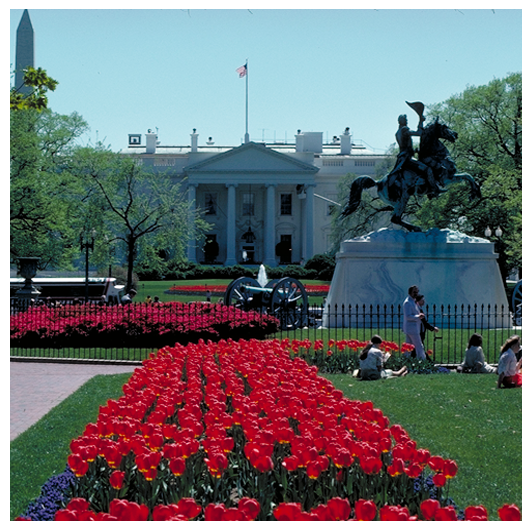

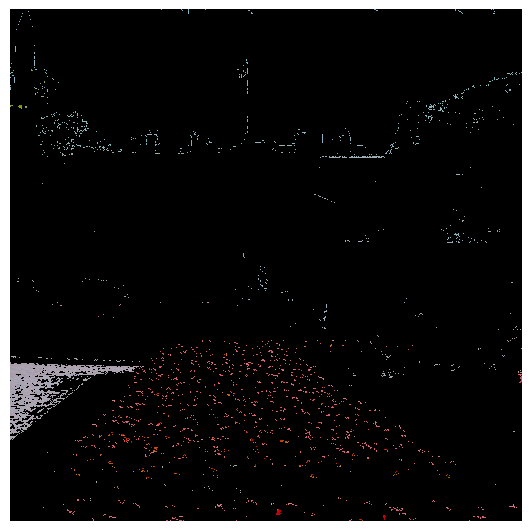

In [123]:
imshow(img_rgb)
imshow(img_rgb_out)

1. As we can see that from the histogram above, it is a multimodel distribution with 3 peaks, meaning that at least there are 3 classes in the image 1600.jpg

### Defining function for calculating a simple Mean Intersection over Union (mIoU)

In [442]:
def mIoU(image, area):
    temp_calc_bool = image[:, :, 0].astype(np.bool_) | image[:, :, 1].astype(np.bool_) | image[:, :, 2].astype(np.bool_)
    IoU = np.logical_and(temp_calc_bool, area.astype(np.bool_)).sum() / np.logical_or(temp_calc_bool, area.astype(np.bool_)).sum()
    return IoU

def precision(image, area):
    return NotImplementedError

def recall(image, area):
    return NotImplementedError

In [458]:
mIoU(result, segmented_area)

0.7622486940003166

In [214]:
img_hsv_out = img_hsv.copy()
hsv_euc_dist = []
for r in tqdm(range(0, num_rows)):
  for c in range(0, num_cols):
    euc_dist = euclidean_dist(img_hsv[r, c], img_hsv_crop)
    hsv_euc_dist.append(euc_dist)

    if euc_dist < 85.:
      img_hsv_out[r, c] = img_hsv[r, c]
    else:
      img_hsv_out[r, c] = np.array([0, 0, 0], dtype=np.uint8)

100%|██████████| 512/512 [00:07<00:00, 70.51it/s]


(array([4.0500e+02, 1.1790e+03, 2.0610e+03, 1.3128e+04, 5.0360e+03,
        3.4040e+03, 2.7110e+03, 2.3630e+03, 1.7510e+03, 1.2180e+03,
        9.5800e+02, 9.4300e+02, 8.7000e+02, 1.0220e+03, 1.8380e+03,
        2.2710e+03, 2.7240e+03, 3.1780e+03, 3.9160e+03, 4.6060e+03,
        5.2470e+03, 5.0180e+03, 5.1220e+03, 5.4050e+03, 7.1960e+03,
        1.1401e+04, 1.7650e+04, 3.8161e+04, 3.2501e+04, 1.8840e+04,
        1.3435e+04, 7.9830e+03, 1.0420e+04, 4.3420e+03, 4.2010e+03,
        3.2890e+03, 2.8120e+03, 2.4710e+03, 2.1510e+03, 1.8920e+03,
        1.5310e+03, 1.0870e+03, 8.4100e+02, 3.1100e+02, 2.0900e+02,
        1.5900e+02, 6.2000e+01, 5.9000e+01, 2.7000e+01, 2.7390e+03]),
 array([  0.39148465,   7.12860072,  13.86571679,  20.60283286,
         27.33994893,  34.077065  ,  40.81418107,  47.55129713,
         54.2884132 ,  61.02552927,  67.76264534,  74.49976141,
         81.23687748,  87.97399355,  94.71110962, 101.44822569,
        108.18534176, 114.92245783, 121.6595739 , 128.39668997

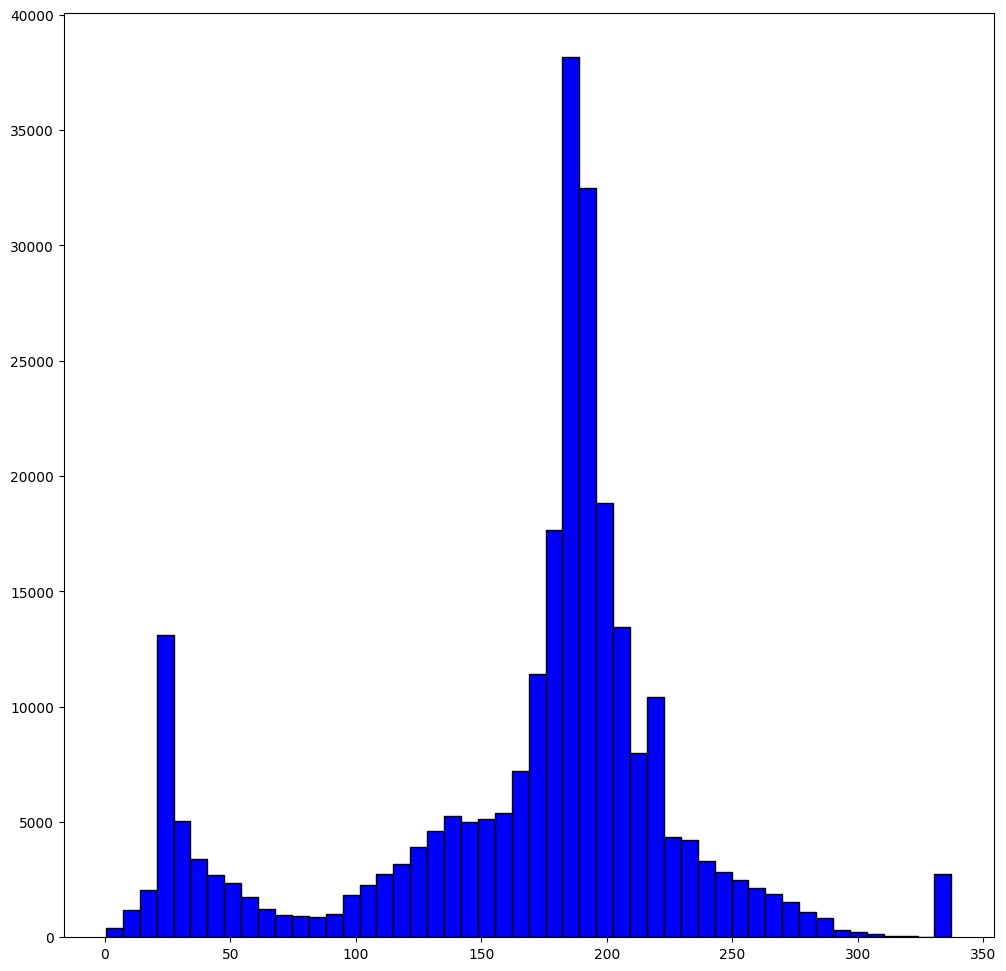

In [19]:
plt.figure(figsize = [12, 12])
plt.hist(hsv_euc_dist, bins= 50, edgecolor = 'black', color = 'b')

In [221]:
img_lab_out = img_lab.copy()
lab_euc_dist = []
for r in tqdm(range(0, num_rows)):
  for c in range(0, num_cols):
    euc_dist = euclidean_dist(img_lab[r, c], img_lab_crop)
    lab_euc_dist.append(euc_dist)

    if euc_dist < 60.:
      img_lab_out[r, c] = img_lab[r, c]
    else:
      img_lab_out[r, c] = np.array([0., 128., 128.])

100%|██████████| 512/512 [00:07<00:00, 69.97it/s]


(array([6.4000e+01, 3.6900e+02, 7.0700e+02, 1.6170e+03, 4.5500e+03,
        3.6920e+03, 3.1540e+03, 1.9450e+03, 2.6790e+03, 2.5060e+03,
        1.7320e+03, 1.5750e+03, 1.6120e+03, 1.5620e+03, 1.3960e+03,
        1.3390e+03, 1.0710e+03, 9.9900e+02, 1.0210e+03, 1.0760e+03,
        7.9000e+02, 7.5400e+02, 7.0800e+02, 7.2100e+02, 6.8600e+02,
        5.6900e+02, 6.1300e+02, 6.1800e+02, 5.4000e+02, 4.9900e+02,
        4.8000e+02, 5.4300e+02, 5.5000e+02, 5.0300e+02, 5.1800e+02,
        5.5500e+02, 6.8100e+02, 7.2300e+02, 8.6800e+02, 1.1540e+03,
        1.8840e+03, 3.3240e+03, 7.3560e+03, 1.1672e+04, 1.7499e+04,
        2.3160e+04, 1.8300e+04, 1.0909e+04, 6.6750e+03, 4.8340e+03,
        3.9440e+03, 3.5530e+03, 3.1060e+03, 2.8380e+03, 2.3100e+03,
        2.3210e+03, 2.2440e+03, 2.3730e+03, 2.3210e+03, 2.4560e+03,
        2.6200e+03, 2.5370e+03, 2.5040e+03, 2.3670e+03, 1.0736e+04,
        2.6700e+02, 2.0400e+02, 2.0500e+02, 2.1200e+02, 1.6800e+02,
        1.4700e+02, 1.4400e+02, 1.6600e+02, 1.67

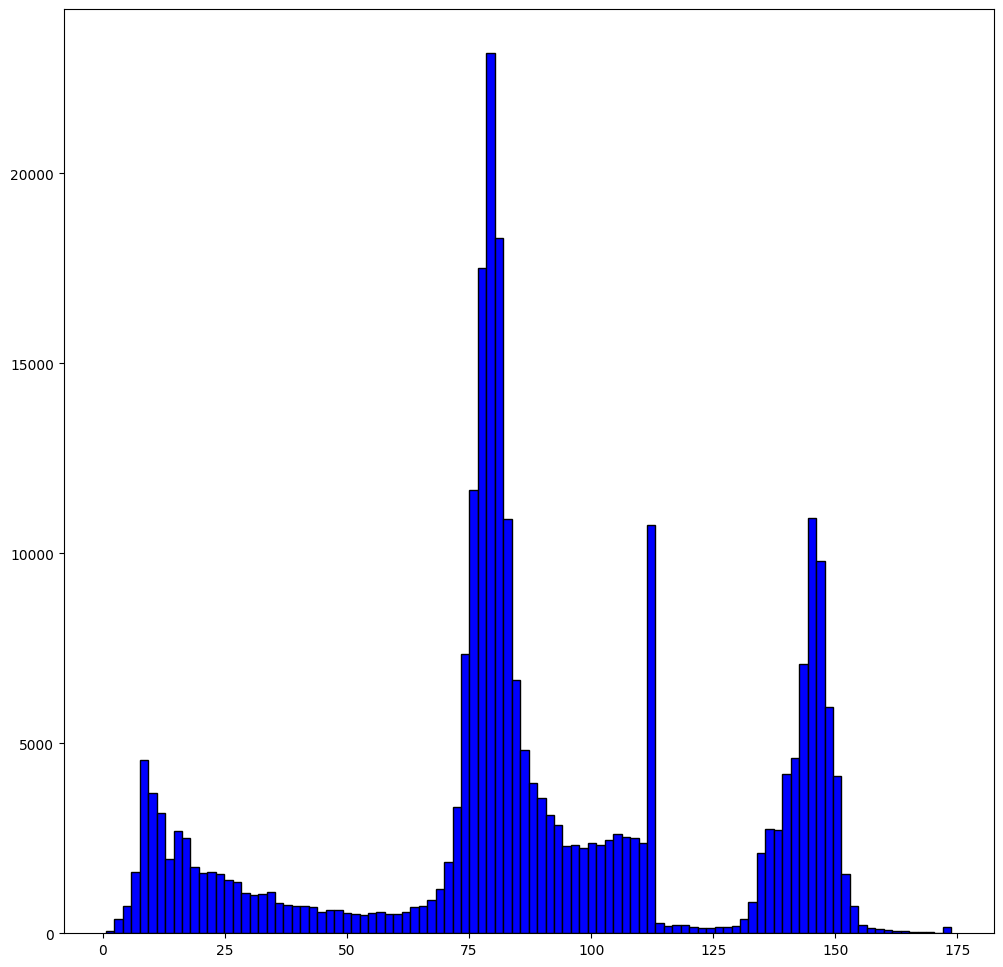

In [129]:
plt.figure(figsize = [12, 12])
plt.hist(lab_euc_dist, bins= 100, edgecolor = 'black', color = 'b')

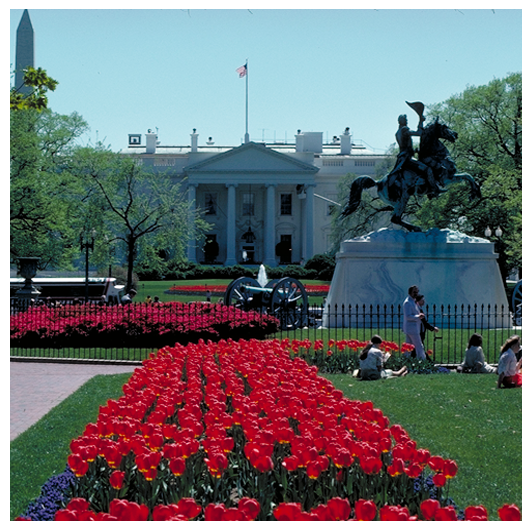

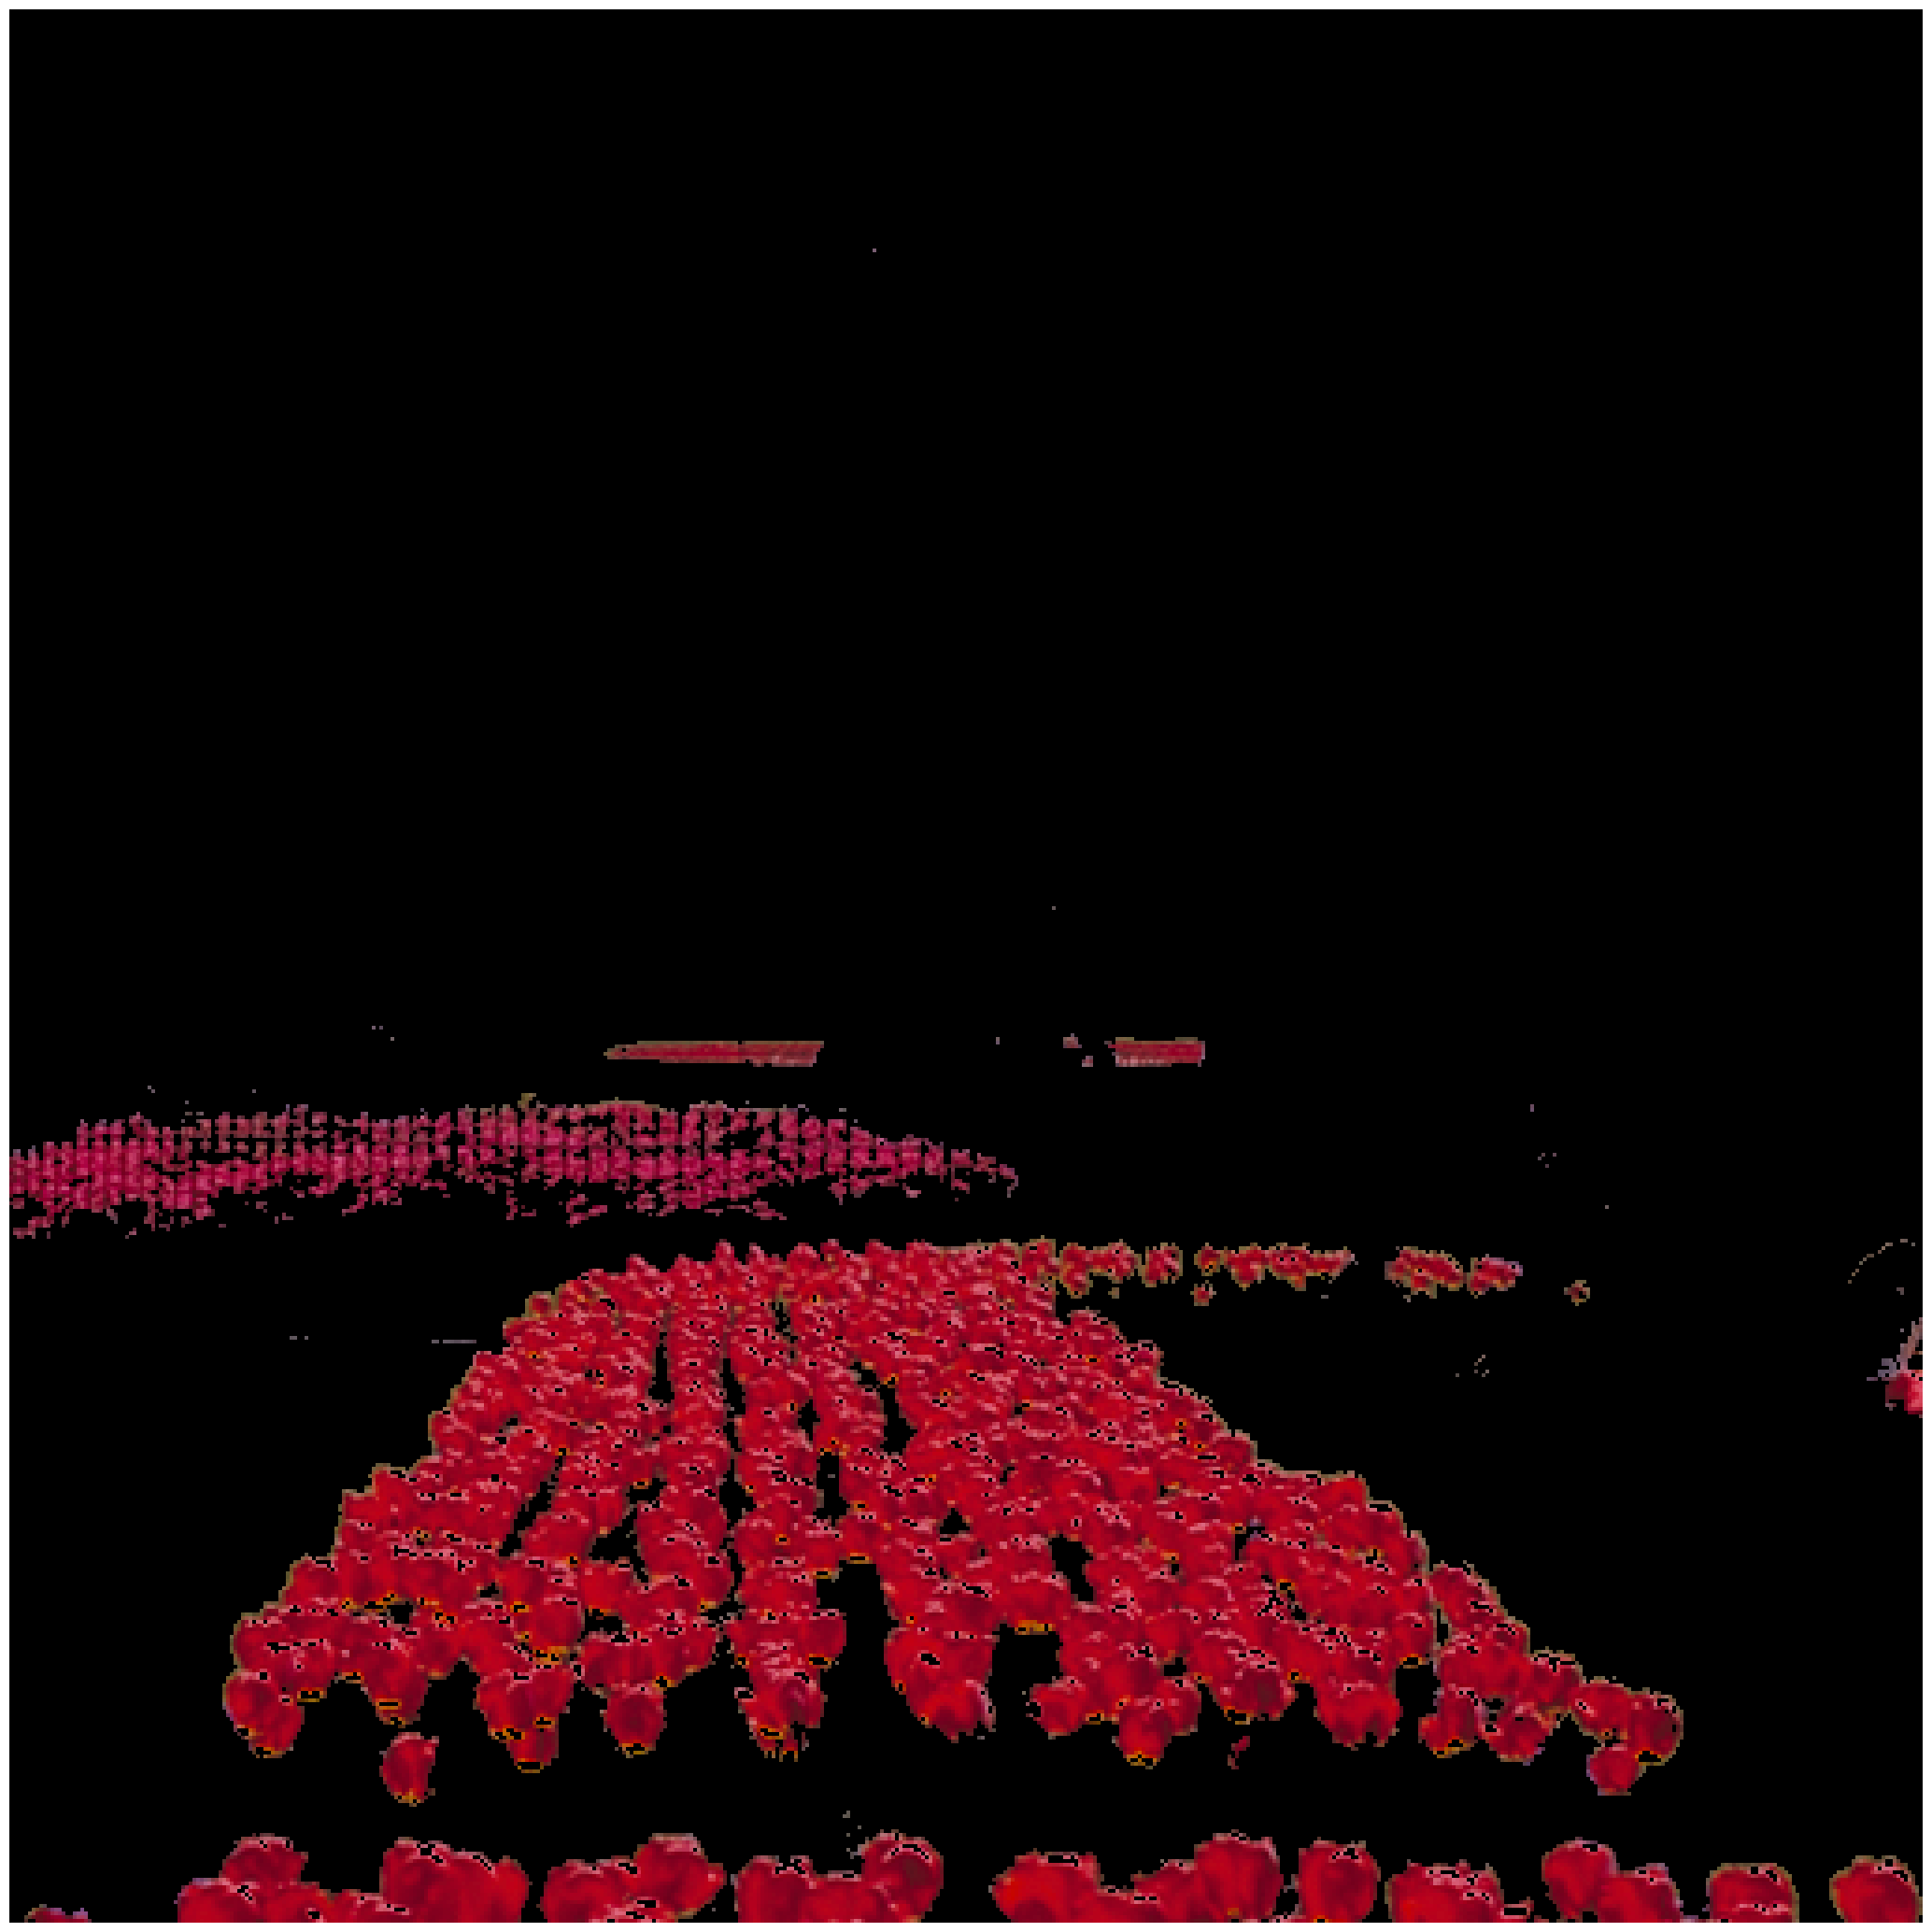

In [222]:
imshow(img_rgb)
imshow(cv2.cvtColor(img_lab_out, cv2.COLOR_LAB2RGB), zoom = 4)

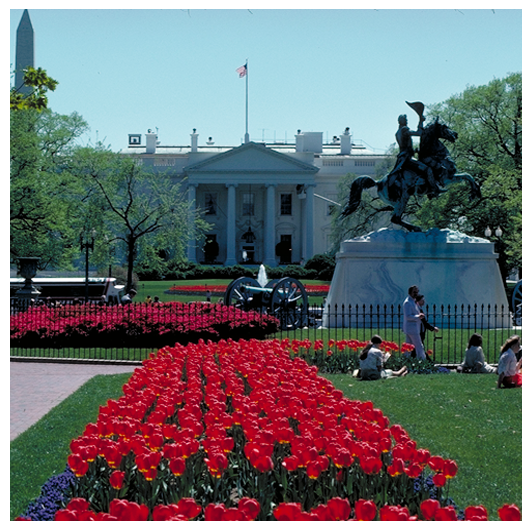

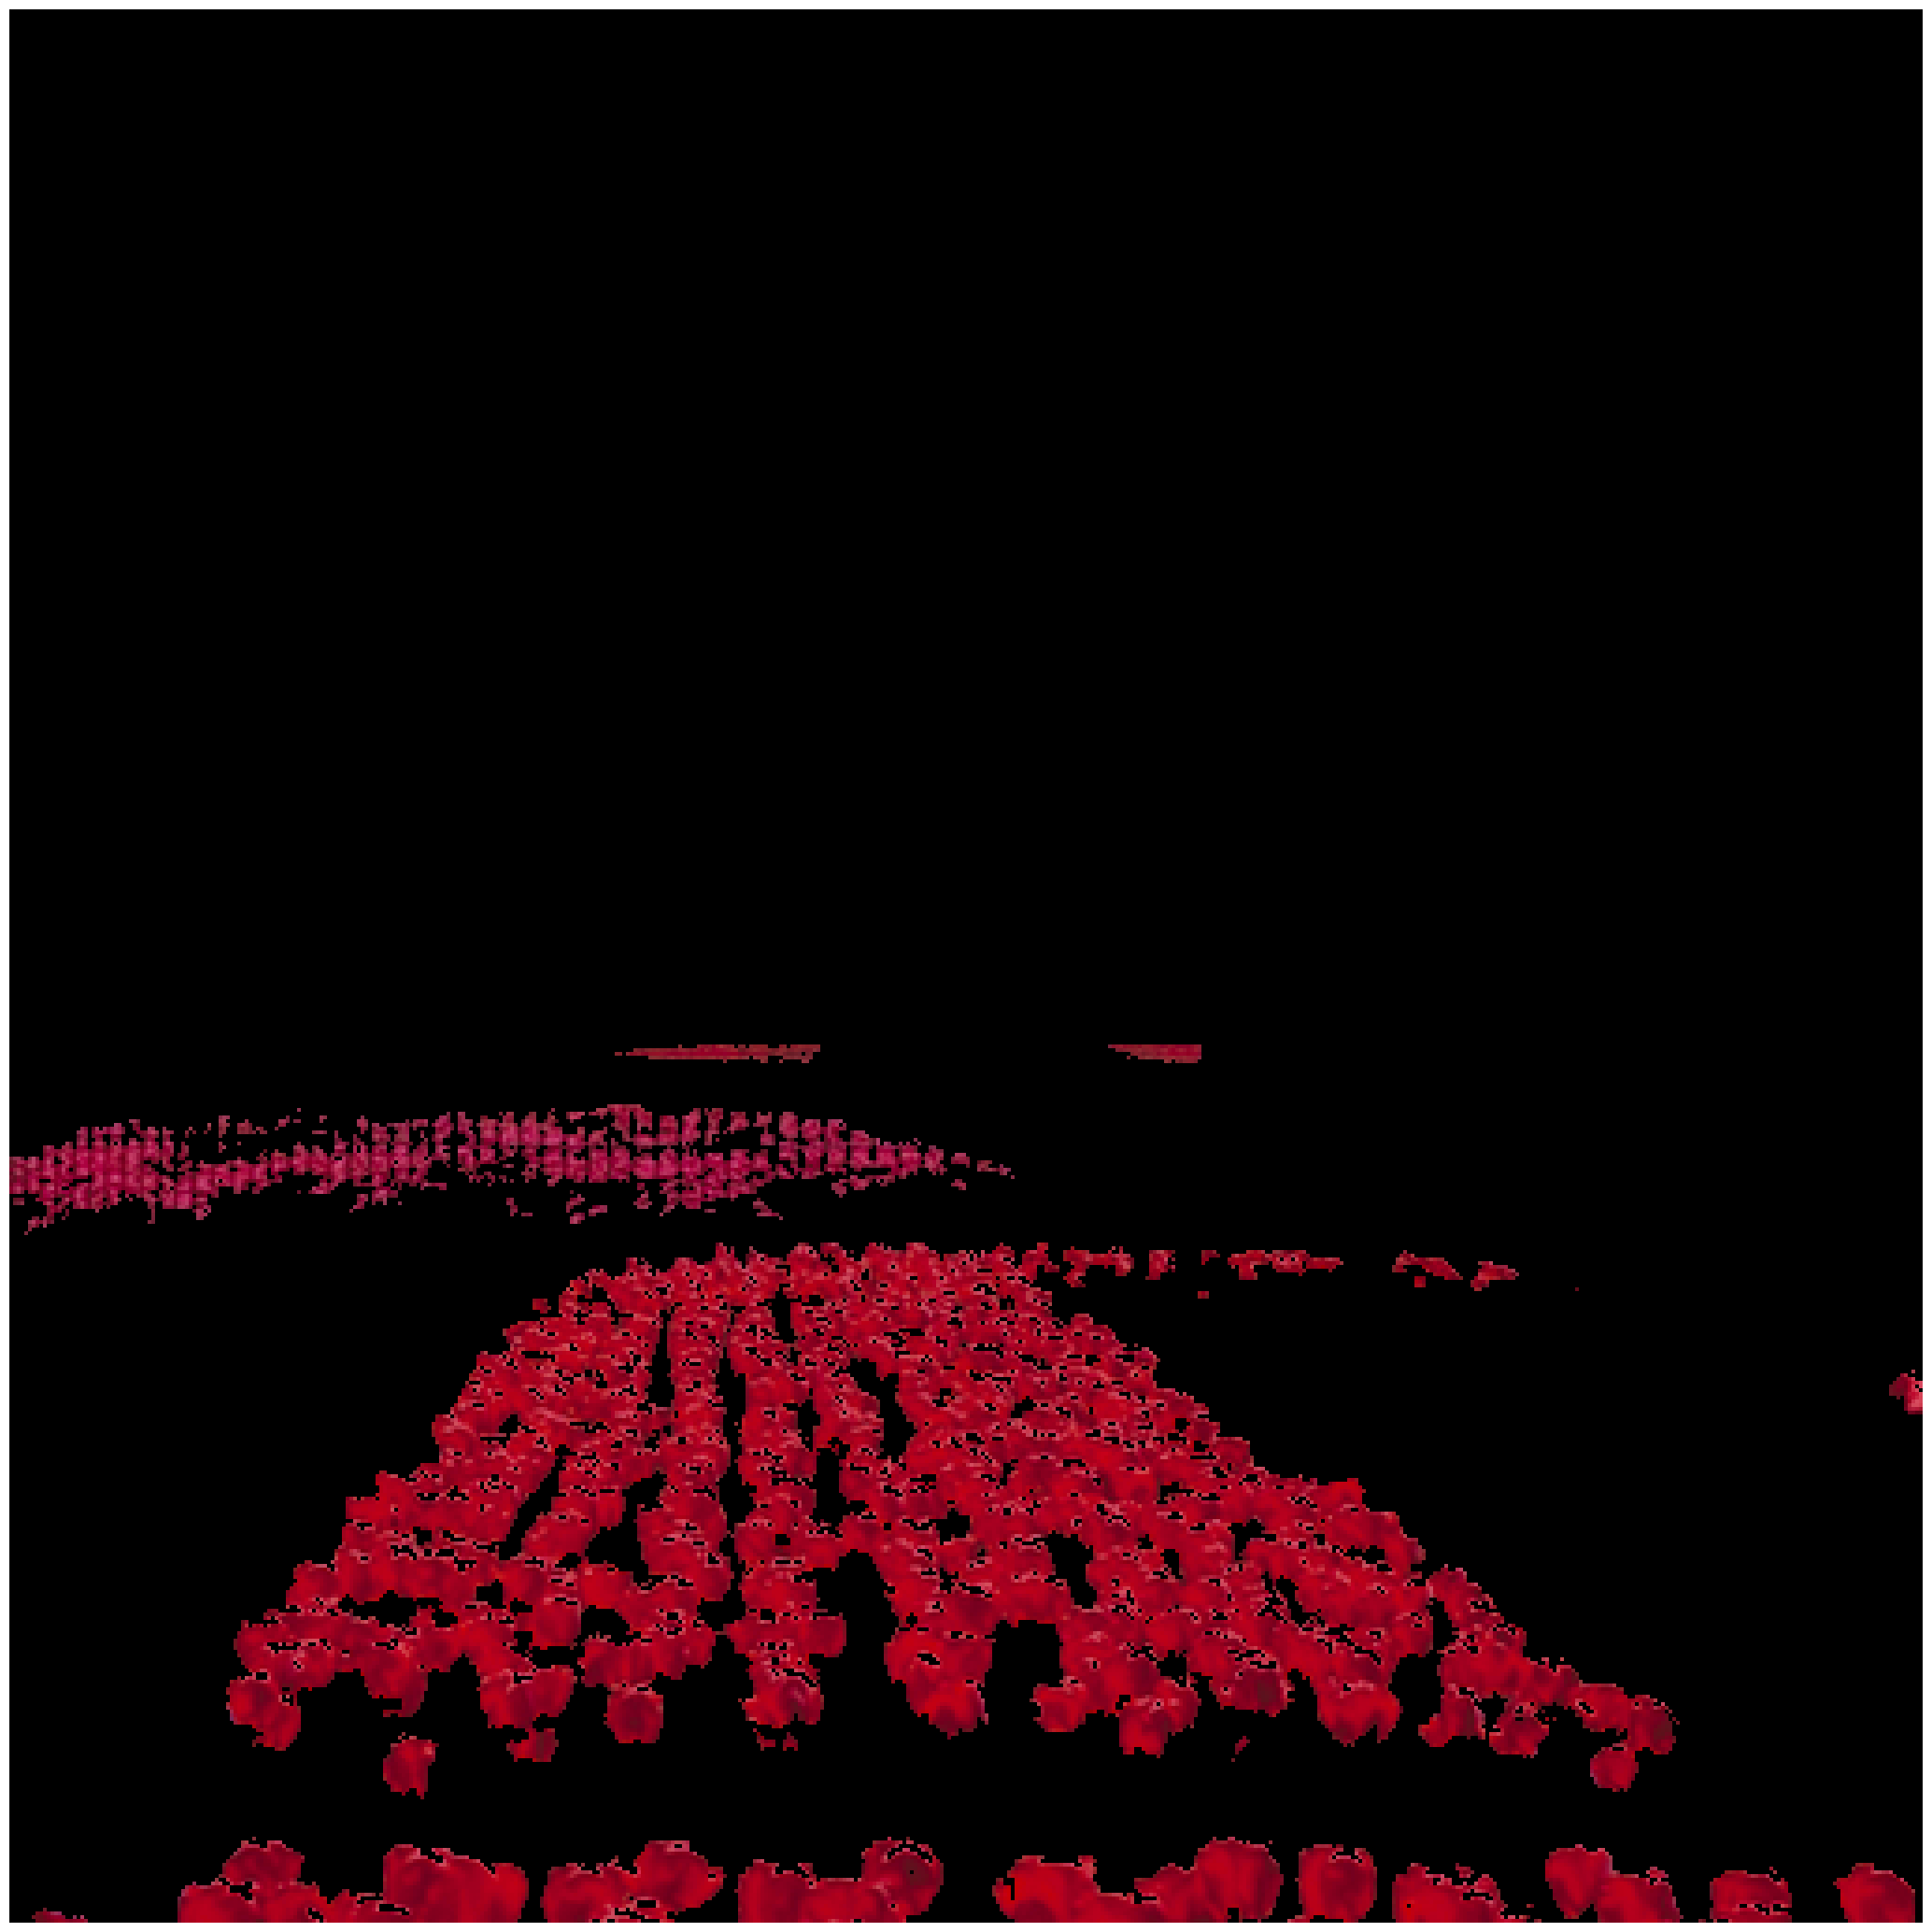

In [215]:
imshow(img_rgb)
imshow(cv2.cvtColor(img_hsv_out, cv2.COLOR_HSV2RGB), zoom = 4)

In [4]:
kmeans = KMeans(n_clusters = 3, n_init = 20)
kmeans.fit(img_rgb.reshape(-1, 3))

KMeans(n_clusters=3, n_init=20)

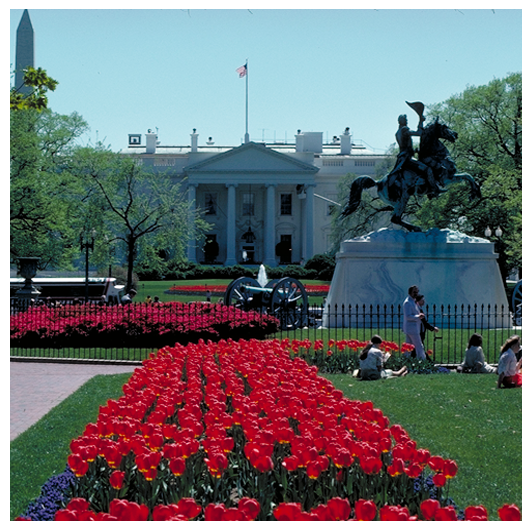

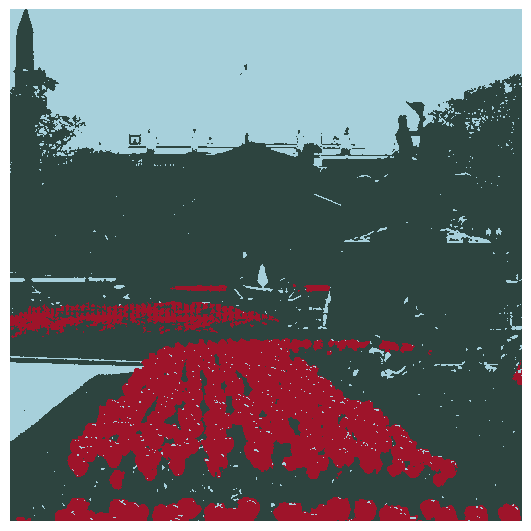

In [5]:
imshow(img_rgb)
seg_rgb_vals = kmeans.cluster_centers_[kmeans.labels_]

seg_img = seg_rgb_vals.reshape(img_rgb.shape)
imshow(seg_img.astype(np.uint8))

In [44]:
def mahalanobis_dist(x, train_rgb):
    mu = np.mean(train_rgb, axis = (0, 1))
    cov = np.cov(train_rgb, rowvar=False)
    temp = x - mu
    mahalanobis = np.dot(np.dot(temp, np.linalg.inv(cov)), temp)
    return mahalanobis ** 0.5

In [7]:
def maximum_likelihood(x, train_rgb, d, prob):
    mu = np.mean(train_rgb, axis = 0)
    covariance = np.cov(train_rgb, rowvar = False)
    temp = x - mu
    gx = -0.5 * np.dot(np.dot(temp, np.linalg.inv(covariance)), temp) - d/2 * np.log(2 * np.pi) - 1/2 * np.log(np.linalg.det(covariance)) + np.log(prob)
    return gx